In [11]:
def main(model_name, data_path, output_dir):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    
    # 定义参数范围
    max_seq_length = 128
    batch_sizes = [8, 16]
    learning_rates = [5e-5, 3e-5]
    epochs = [2, 3]

    best_accuracy = 0
    best_params = {}

    # 确保日志目录存在，如果不存在则创建
    logging_dir = f'{output_dir}/logs'  # 将日志文件保存在output_dir指定的目录下的logs子目录
    os.makedirs(logging_dir, exist_ok=True)

    # 首次循环：使用数据集的前400条数据来寻找最佳参数
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for num_epochs in epochs:
                print(f"Training with batch size {batch_size}, learning rate {learning_rate}, epochs {num_epochs}")
                
                model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(pd.read_csv(data_path)['情感分析'])))
                # 使用前400条数据进行训练和评估
                train_dataset, test_dataset = load_dataset(data_path, tokenizer, max_seq_length, use_small_subset=True)

                training_args = TrainingArguments(
                    output_dir=output_dir,
                    num_train_epochs=num_epochs,
                    per_device_train_batch_size=batch_size,
                    per_device_eval_batch_size=batch_size,
                    learning_rate=learning_rate,
                    warmup_steps=500,
                    weight_decay=0.01,
                    evaluation_strategy="epoch",
                    logging_dir=logging_dir,  # 使用上面定义的logging_dir
                    save_strategy="no"  # 在寻找最佳参数时不保存模型
                )

                trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=test_dataset,
                    compute_metrics=compute_metrics
                )

                trainer.train()
                eval_results = trainer.evaluate()

                if eval_results['eval_accuracy'] > best_accuracy:
                    best_accuracy = eval_results['eval_accuracy']
                    best_params = {
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'epochs': num_epochs,
                        'max_seq_length': max_seq_length
                    }
                    print(f"New best accuracy: {best_accuracy} with params {best_params}")

    print(f"Best accuracy: {best_accuracy} with params {best_params}")

    # 使用最佳参数和全部数据集重新训练模型
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(pd.read_csv(data_path)['情感分析'])))
    # 使用全部数据集
    train_dataset, test_dataset = load_dataset(data_path, tokenizer, best_params['max_seq_length'], use_small_subset=False)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=best_params['epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        learning_rate=best_params['learning_rate'],
        warmup_steps=500,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_dir=logging_dir,  # 在最终训练时使用定义的日志目录
        save_strategy="epoch"  # 在最终训练时保存模型
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # 保存模型和tokenizer到指定的输出目录
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Model saved to {output_dir}")



In [33]:
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import torch
import numpy as np


def load_dataset(file_path, tokenizer, max_length, use_small_subset=True):
    # 加载数据集，根据use_small_subset决定是否只使用前400条数据
    data = pd.read_csv(file_path)
    if use_small_subset:
        data = data.head(400)
    X_train, X_test, y_train, y_test = train_test_split(data['标题/微博内容'], data['情感分析'], test_size=0.2, random_state=42)

    # 编码数据
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length)

    # 转换为PyTorch数据集格式
    class Dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(int(self.labels.iloc[idx]))
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = Dataset(train_encodings, y_train)
    test_dataset = Dataset(test_encodings, y_test)

    return train_dataset, test_dataset

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
desktop_path = '/Users/xuguangjie/Desktop'
model_folder = 'model'
log_folder = 'log'

output_dir = f'{desktop_path}/{model_folder}'
logging_dir = f'{output_dir}/{log_folder}' 

In [13]:
import os

model_name = 'hfl/chinese-macbert-base'
data_path = '/Users/xuguangjie/Desktop/resampled.csv'
# output_dir = '/Users/xuguangjie/Desktop/model/'

# 调用main函数开始训练
main(model_name, data_path, output_dir)


Training with batch size 8, learning rate 5e-05, epochs 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 40/80 [00:22<00:15,  2.57it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 50%|█████     | 40/80 [00:23<00:15,  2.57it/s]

{'eval_loss': 1.8085854053497314, 'eval_accuracy': 0.1875, 'eval_f1': 0.045112781954887216, 'eval_precision': 0.026785714285714284, 'eval_recall': 0.14285714285714285, 'eval_runtime': 0.9864, 'eval_samples_per_second': 81.106, 'eval_steps_per_second': 10.138, 'epoch': 1.0}


100%|██████████| 80/80 [00:38<00:00,  2.61it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
100%|██████████| 80/80 [00:39<00:00,  2.02it/s]


{'eval_loss': 1.7071969509124756, 'eval_accuracy': 0.2, 'eval_f1': 0.056619570905285195, 'eval_precision': 0.06390977443609022, 'eval_recall': 0.14835164835164835, 'eval_runtime': 0.89, 'eval_samples_per_second': 89.883, 'eval_steps_per_second': 11.235, 'epoch': 2.0}
{'train_runtime': 39.5701, 'train_samples_per_second': 16.174, 'train_steps_per_second': 2.022, 'train_loss': 1.9103116989135742, 'epoch': 2.0}


 90%|█████████ | 9/10 [00:00<00:00, 12.10it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 10/10 [00:00<00:00, 12.54it/s]


New best accuracy: 0.2 with params {'batch_size': 8, 'learning_rate': 5e-05, 'epochs': 2, 'max_seq_length': 128}
Training with batch size 8, learning rate 5e-05, epochs 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 40/120 [00:15<00:31,  2.58it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 33%|███▎      | 40/120 [00:16<00:31,  2.58it/s]

{'eval_loss': 1.9444401264190674, 'eval_accuracy': 0.1625, 'eval_f1': 0.09927695492912883, 'eval_precision': 0.14696748264523202, 'eval_recall': 0.16495726495726495, 'eval_runtime': 0.8756, 'eval_samples_per_second': 91.367, 'eval_steps_per_second': 11.421, 'epoch': 1.0}


 67%|██████▋   | 80/120 [00:31<00:15,  2.63it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 67%|██████▋   | 80/120 [00:32<00:15,  2.63it/s]

{'eval_loss': 1.6886606216430664, 'eval_accuracy': 0.2625, 'eval_f1': 0.10129870129870129, 'eval_precision': 0.08432338452622427, 'eval_recall': 0.15164835164835164, 'eval_runtime': 0.848, 'eval_samples_per_second': 94.338, 'eval_steps_per_second': 11.792, 'epoch': 2.0}


100%|██████████| 120/120 [00:47<00:00,  2.65it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
100%|██████████| 120/120 [00:48<00:00,  2.46it/s]


{'eval_loss': 1.5758682489395142, 'eval_accuracy': 0.4375, 'eval_f1': 0.2032967032967033, 'eval_precision': 0.2468602825745683, 'eval_recall': 0.23113553113553112, 'eval_runtime': 0.8461, 'eval_samples_per_second': 94.55, 'eval_steps_per_second': 11.819, 'epoch': 3.0}
{'train_runtime': 48.7696, 'train_samples_per_second': 19.684, 'train_steps_per_second': 2.461, 'train_loss': 1.8345536549886068, 'epoch': 3.0}


 90%|█████████ | 9/10 [00:00<00:00, 12.73it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 10/10 [00:00<00:00, 13.16it/s]


New best accuracy: 0.4375 with params {'batch_size': 8, 'learning_rate': 5e-05, 'epochs': 3, 'max_seq_length': 128}
Training with batch size 8, learning rate 3e-05, epochs 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 40/80 [00:15<00:15,  2.63it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 40/80 [00:16<00:15,  2.63it/s]

{'eval_loss': 1.8628408908843994, 'eval_accuracy': 0.25, 'eval_f1': 0.09384436701509873, 'eval_precision': 0.0738095238095238, 'eval_recall': 0.16507936507936508, 'eval_runtime': 0.8477, 'eval_samples_per_second': 94.375, 'eval_steps_per_second': 11.797, 'epoch': 1.0}


100%|██████████| 80/80 [00:31<00:00,  2.58it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 80/80 [00:32<00:00,  2.45it/s]


{'eval_loss': 1.7266359329223633, 'eval_accuracy': 0.2125, 'eval_f1': 0.08272162619988707, 'eval_precision': 0.11311154598825832, 'eval_recall': 0.15714285714285717, 'eval_runtime': 0.8475, 'eval_samples_per_second': 94.394, 'eval_steps_per_second': 11.799, 'epoch': 2.0}
{'train_runtime': 32.5566, 'train_samples_per_second': 19.658, 'train_steps_per_second': 2.457, 'train_loss': 1.9385005950927734, 'epoch': 2.0}


 90%|█████████ | 9/10 [00:00<00:00, 12.74it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 10/10 [00:00<00:00, 13.19it/s]


Training with batch size 8, learning rate 3e-05, epochs 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 40/120 [00:15<00:30,  2.66it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 33%|███▎      | 40/120 [00:16<00:30,  2.66it/s]

{'eval_loss': 2.0507471561431885, 'eval_accuracy': 0.0875, 'eval_f1': 0.06504237288135593, 'eval_precision': 0.09276763336913714, 'eval_recall': 0.18571428571428572, 'eval_runtime': 0.8485, 'eval_samples_per_second': 94.285, 'eval_steps_per_second': 11.786, 'epoch': 1.0}


 67%|██████▋   | 80/120 [00:31<00:15,  2.63it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 67%|██████▋   | 80/120 [00:32<00:15,  2.63it/s]

{'eval_loss': 1.7416661977767944, 'eval_accuracy': 0.3125, 'eval_f1': 0.14366117373192844, 'eval_precision': 0.18984962406015038, 'eval_recall': 0.1728937728937729, 'eval_runtime': 0.8687, 'eval_samples_per_second': 92.09, 'eval_steps_per_second': 11.511, 'epoch': 2.0}


100%|██████████| 120/120 [00:47<00:00,  2.59it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
100%|██████████| 120/120 [00:48<00:00,  2.47it/s]


{'eval_loss': 1.6299240589141846, 'eval_accuracy': 0.3625, 'eval_f1': 0.17280787128562305, 'eval_precision': 0.23952215032354404, 'eval_recall': 0.2053724053724054, 'eval_runtime': 0.8501, 'eval_samples_per_second': 94.102, 'eval_steps_per_second': 11.763, 'epoch': 3.0}
{'train_runtime': 48.512, 'train_samples_per_second': 19.789, 'train_steps_per_second': 2.474, 'train_loss': 1.8985558827718099, 'epoch': 3.0}


 90%|█████████ | 9/10 [00:00<00:00, 12.74it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 10/10 [00:00<00:00, 13.18it/s]


Training with batch size 16, learning rate 5e-05, epochs 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 20/40 [00:14<00:12,  1.55it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 20/40 [00:14<00:12,  1.55it/s]

{'eval_loss': 1.9154415130615234, 'eval_accuracy': 0.225, 'eval_f1': 0.05247813411078717, 'eval_precision': 0.03214285714285715, 'eval_recall': 0.14285714285714285, 'eval_runtime': 0.8481, 'eval_samples_per_second': 94.332, 'eval_steps_per_second': 5.896, 'epoch': 1.0}


100%|██████████| 40/40 [00:27<00:00,  1.59it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


{'eval_loss': 1.8010591268539429, 'eval_accuracy': 0.25, 'eval_f1': 0.11606076122205156, 'eval_precision': 0.1138861138861139, 'eval_recall': 0.17777777777777778, 'eval_runtime': 0.8275, 'eval_samples_per_second': 96.678, 'eval_steps_per_second': 6.042, 'epoch': 2.0}
{'train_runtime': 28.3432, 'train_samples_per_second': 22.58, 'train_steps_per_second': 1.411, 'train_loss': 2.0112672805786134, 'epoch': 2.0}


100%|██████████| 5/5 [00:00<00:00,  6.87it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


Training with batch size 16, learning rate 5e-05, epochs 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 20/60 [00:12<00:25,  1.59it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 20/60 [00:13<00:25,  1.59it/s]

{'eval_loss': 2.144057035446167, 'eval_accuracy': 0.0375, 'eval_f1': 0.04399585921325051, 'eval_precision': 0.028073916133617625, 'eval_recall': 0.21428571428571427, 'eval_runtime': 0.8257, 'eval_samples_per_second': 96.889, 'eval_steps_per_second': 6.056, 'epoch': 1.0}


 67%|██████▋   | 40/60 [00:26<00:12,  1.59it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 40/60 [00:27<00:12,  1.59it/s]

{'eval_loss': 1.877971887588501, 'eval_accuracy': 0.225, 'eval_f1': 0.1453267784846732, 'eval_precision': 0.14395604395604394, 'eval_recall': 0.1973137973137973, 'eval_runtime': 0.8258, 'eval_samples_per_second': 96.874, 'eval_steps_per_second': 6.055, 'epoch': 2.0}


100%|██████████| 60/60 [00:39<00:00,  1.56it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


{'eval_loss': 1.6957120895385742, 'eval_accuracy': 0.325, 'eval_f1': 0.1382641748495407, 'eval_precision': 0.1834065934065934, 'eval_recall': 0.16630036630036632, 'eval_runtime': 0.8309, 'eval_samples_per_second': 96.282, 'eval_steps_per_second': 6.018, 'epoch': 3.0}
{'train_runtime': 40.8062, 'train_samples_per_second': 23.526, 'train_steps_per_second': 1.47, 'train_loss': 1.978778330485026, 'epoch': 3.0}


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


Training with batch size 16, learning rate 3e-05, epochs 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 20/40 [00:12<00:12,  1.60it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 20/40 [00:13<00:12,  1.60it/s]

{'eval_loss': 1.9376503229141235, 'eval_accuracy': 0.225, 'eval_f1': 0.05247813411078717, 'eval_precision': 0.03214285714285715, 'eval_recall': 0.14285714285714285, 'eval_runtime': 0.829, 'eval_samples_per_second': 96.506, 'eval_steps_per_second': 6.032, 'epoch': 1.0}


100%|██████████| 40/40 [00:26<00:00,  1.59it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


{'eval_loss': 1.8474235534667969, 'eval_accuracy': 0.3, 'eval_f1': 0.11970816069176725, 'eval_precision': 0.08458292179222412, 'eval_recall': 0.20476190476190476, 'eval_runtime': 0.8252, 'eval_samples_per_second': 96.951, 'eval_steps_per_second': 6.059, 'epoch': 2.0}
{'train_runtime': 27.1703, 'train_samples_per_second': 23.555, 'train_steps_per_second': 1.472, 'train_loss': 2.042407989501953, 'epoch': 2.0}


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


Training with batch size 16, learning rate 3e-05, epochs 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 20/60 [00:12<00:25,  1.58it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 20/60 [00:13<00:25,  1.58it/s]

{'eval_loss': 2.18823504447937, 'eval_accuracy': 0.025, 'eval_f1': 0.007722007722007722, 'eval_precision': 0.003968253968253968, 'eval_recall': 0.14285714285714285, 'eval_runtime': 0.8235, 'eval_samples_per_second': 97.147, 'eval_steps_per_second': 6.072, 'epoch': 1.0}


 67%|██████▋   | 40/60 [00:27<00:12,  1.59it/s]

{'eval_loss': 2.0064620971679688, 'eval_accuracy': 0.125, 'eval_f1': 0.07944657778544821, 'eval_precision': 0.08224489795918366, 'eval_recall': 0.2095238095238095, 'eval_runtime': 0.8246, 'eval_samples_per_second': 97.016, 'eval_steps_per_second': 6.064, 'epoch': 2.0}


100%|██████████| 60/60 [00:39<00:00,  1.59it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


{'eval_loss': 1.7845916748046875, 'eval_accuracy': 0.25, 'eval_f1': 0.12828932571634205, 'eval_precision': 0.12116192630898515, 'eval_recall': 0.15360195360195358, 'eval_runtime': 0.826, 'eval_samples_per_second': 96.858, 'eval_steps_per_second': 6.054, 'epoch': 3.0}
{'train_runtime': 40.6225, 'train_samples_per_second': 23.632, 'train_steps_per_second': 1.477, 'train_loss': 2.042161814371745, 'epoch': 3.0}


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


Best accuracy: 0.4375 with params {'batch_size': 8, 'learning_rate': 5e-05, 'epochs': 3, 'max_seq_length': 128}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 26%|██▌       | 500/1905 [03:14<08:50,  2.65it/s]

{'loss': 1.3207, 'learning_rate': 5e-05, 'epoch': 0.79}


 33%|███▎      | 635/1905 [04:20<10:27,  2.02it/s]

{'eval_loss': 0.5608967542648315, 'eval_accuracy': 0.8007874015748031, 'eval_f1': 0.7943760748414109, 'eval_precision': 0.7952919940507639, 'eval_recall': 0.8041790608279779, 'eval_runtime': 14.8858, 'eval_samples_per_second': 85.316, 'eval_steps_per_second': 10.681, 'epoch': 1.0}


 52%|█████▏    | 1000/1905 [06:50<05:52,  2.56it/s] 

{'loss': 0.5036, 'learning_rate': 3.2206405693950184e-05, 'epoch': 1.57}


 67%|██████▋   | 1270/1905 [08:48<03:59,  2.66it/s]

{'eval_loss': 0.32081928849220276, 'eval_accuracy': 0.9165354330708662, 'eval_f1': 0.9173059727935745, 'eval_precision': 0.9166562796731014, 'eval_recall': 0.9183934632835113, 'eval_runtime': 14.2848, 'eval_samples_per_second': 88.906, 'eval_steps_per_second': 11.131, 'epoch': 2.0}


 79%|███████▊  | 1500/1905 [10:23<02:31,  2.67it/s]  

{'loss': 0.238, 'learning_rate': 1.4412811387900358e-05, 'epoch': 2.36}


100%|██████████| 1905/1905 [13:12<00:00,  2.70it/s]

{'eval_loss': 0.2621508538722992, 'eval_accuracy': 0.9393700787401574, 'eval_f1': 0.9385736489258754, 'eval_precision': 0.9391349425666331, 'eval_recall': 0.9410878632851232, 'eval_runtime': 13.861, 'eval_samples_per_second': 91.624, 'eval_steps_per_second': 11.471, 'epoch': 3.0}


100%|██████████| 1905/1905 [13:20<00:00,  2.38it/s]


{'train_runtime': 800.3004, 'train_samples_per_second': 19.039, 'train_steps_per_second': 2.38, 'train_loss': 0.5665147335823439, 'epoch': 3.0}
Model saved to /Users/xuguangjie/Desktop/model


In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset

# 定义文本数据集
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# 定义数据加载和预处理函数
def load_and_preprocess_data(file_path, tokenizer, max_length, start_row=0, num_rows=1000):
    data = pd.read_csv(file_path).iloc[start_row:start_row+num_rows]
    encodings = tokenizer(data['标题/微博内容'].tolist(), truncation=True, padding='max_length', max_length=max_length)
    dataset = TextDataset(encodings)
    return dataset, data

# 定义预测函数
def predict(model, dataset):
    model.eval()
    predictions = []
    with torch.no_grad():
        for item in dataset:
            inputs = {key: value.unsqueeze(0) for key, value in item.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            predictions.append(logits.argmax(dim=1).item())
    return predictions

# 模型和分词器加载
model_name = 'hfl/chinese-macbert-base'
model_path = '/Users/xuguangjie/Desktop/model'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_path)

# 预测数据路径
data_path = '/Users/xuguangjie/Desktop/shanghaidata.csv'
predicted_data_path = '/Users/xuguangjie/Desktop/predicted_shanghaidata.csv'
max_length = 128










/Users/xuguangjie/opt/anaconda3/envs/mpitest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 预测并保存第1至1000条数据的结果
dataset1, data1 = load_and_preprocess_data(data_path, tokenizer, max_length, start_row=0, num_rows=1000)
predictions1 = predict(model, dataset1)
data1['预测情感'] = predictions1
data1.to_csv(predicted_data_path, index=False)  # 保存第一批预测结果
# 预测并追加保存第1001至10000条数据的结果
dataset2, data2 = load_and_preprocess_data(data_path, tokenizer, max_length, start_row=1000, num_rows=9000)
predictions2 = predict(model, dataset2)
data2['预测情感'] = predictions2
data2.to_csv(predicted_data_path, mode='a', index=False, header=False)  # 追加第二批预测结果

print("预测完成，所有结果已保存至", predicted_data_path)


/var/folders/b_/l4nmc1qn6tx1wnl2plq59xcc0000gn/T/ipykernel_54684/1085990253.py:20: DtypeWarning: Columns (0,14,17,19,20,21,22,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path).iloc[start_row:start_row+num_rows]


In [3]:
data_path = '/Users/xuguangjie/Desktop/shanghaibuchong.csv'
predicted_data_path = '/Users/xuguangjie/Desktop/predicted_shanghaidata.csv'
max_length = 128
# 预测并追加保存第1001至10000条数据的结果
dataset2, data2 = load_and_preprocess_data(data_path, tokenizer, max_length, start_row=1, num_rows=9999)
predictions2 = predict(model, dataset2)
data2['预测情感'] = predictions2
data2.to_csv(predicted_data_path, mode='a', index=False, header=False)  # 追加第二批预测结果

print("预测完成，所有结果已保存至", predicted_data_path)

预测完成，所有结果已保存至 /Users/xuguangjie/Desktop/predicted_shanghaidata.csv


In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# 读取原始数据集
data = pd.read_csv('/Users/xuguangjie/Desktop/副本sampled_shanghaidata1.csv')

# 情绪到数字的映射
emotion_to_num = {
    '厌恶': 0,
    '悲伤': 1,
    '信任': 2,
    '期待': 3,
    '其他': 4,  # '其他' 包括 '愤怒', '喜悦', '恐惧', '惊讶'
    '中性': 5
}

# 将特定情感分类为"其他"并转换为数字
emotions_to_combine = ['愤怒', '喜悦', '恐惧', '惊讶']
data['情感分析1'] = data['情感分析1'].apply(lambda x: '其他' if x in emotions_to_combine else x)

# 检查类别分布
class_distribution = data['情感分析1'].value_counts()
print("Modified class distribution:")
print(class_distribution)
data['情感分析1'] = data['情感分析1'].map(emotion_to_num)

# 构建新的数据集
sampl_data = pd.DataFrame({'标题/微博内容': X_resampled.squeeze(), '情感分析1': y_resampled})



# 将新数据集保存到文件
sampled_data.to_csv('/Users/xuguangjie/Desktop/resampled.csv', index=False)

In [53]:
import pandas as pd

# Load the dataset from the specified file path
data = pd.read_csv('/Users/xuguangjie/Desktop/predicted_final.csv')

# Convert the '日期' column to datetime format if it's not already
data['日期'] = pd.to_datetime(data['日期'])

# Group the data by the '日期' column and sample a single post for each date
sampled_data = data.groupby('日期').sample(1)

# Save the sampled data to a new CSV file on the desktop
sampled_data.to_csv('/Users/xuguangjie/Desktop/compare.csv', index=False)

# Note: This script needs to be run in an environment where the file paths are accessible,
# and the pandas library is available. Adjust the file paths as necessary for your setup.


/var/folders/b_/l4nmc1qn6tx1wnl2plq59xcc0000gn/T/ipykernel_1961/1992234491.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/xuguangjie/Desktop/predicted_final.csv')


In [81]:
data = pd.read_csv('/Users/xuguangjie/Desktop/predicted_final.csv')



/var/folders/b_/l4nmc1qn6tx1wnl2plq59xcc0000gn/T/ipykernel_30718/2189759223.py:1: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/xuguangjie/Desktop/predicted_final.csv')


In [1]:
import pandas as pd

# Assuming the data is loaded into a DataFrame named 'data'
# Replace 'your_data_frame' with the actual name of your DataFrame
data = pd.read_csv('/Users/xuguangjie/Desktop/predicted_final.csv')  # Adjust the path to your CSV fil

# If the '日期' column is already of datetime type, convert it directly to the desired format
if pd.api.types.is_datetime64_any_dtype(data['日期']):
    data['日期'] = data['日期'].dt.strftime('%Y-%m-%d')
else:
    # Try to parse and convert dates in string format
    try:
        # Convert string dates to datetime, then format
        data['日期'] = pd.to_datetime(data['日期'], errors='coerce').dt.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Error encountered during conversion: {e}")

# Dictionary to translate emotions from Chinese to English
emotion_to_english = {
    '厌恶': 'Disgust',
    '悲伤': 'Sadness',
    '信任': 'Trust',
    '期待': 'Anticipation',
    '其他': 'Others',
    '中性': 'Neutral'
}

# Translate the '预测情感' column using the dictionary
data['predicted_emotion_english'] = data['预测情感'].map(emotion_to_english)

# Group by date and calculate the proportion of each emotion
grouped_data = data.groupby('日期')['predicted_emotion_english'].value_counts(normalize=True).unstack(fill_value=0)

# Reset the index to make '日期' a column again
grouped_data.reset_index(inplace=True)

# Rename the columns to English if needed
# If your columns are already in English, you can skip this step
# grouped_data.columns = ['Date', 'Disgust', 'Sadness', 'Trust', 'Anticipation', 'Others', 'Neutral']

# Save to CSV on the desktop (adjust the path as needed)
output_path = '/Users/xuguangjie/Desktop/shanghaidata_label.csv'  # Change 'your_username' to your actual username
grouped_data.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")


Data saved to /Users/xuguangjie/Desktop/shanghaidata_label.csv


/var/folders/b_/l4nmc1qn6tx1wnl2plq59xcc0000gn/T/ipykernel_1961/3207991960.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/xuguangjie/Desktop/predicted_final.csv')  # Adjust the path to your CSV file


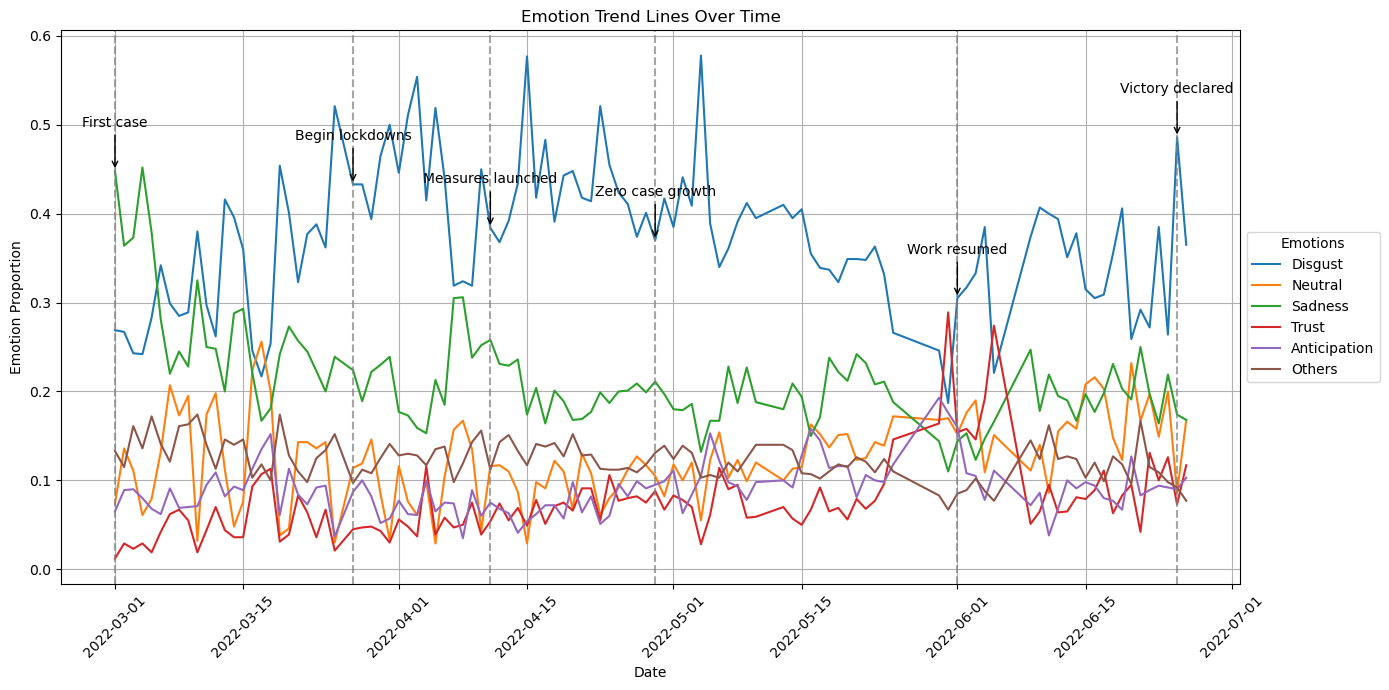

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Read the CSV file into a DataFrame
data = pd.read_csv('/Users/xuguangjie/Desktop/shanghaidata_label.csv')

# Ensure that '日期' is a datetime type
data['日期'] = pd.to_datetime(data['日期'])

# Sorting the emotions based on their values on June 26, 2022
emotion_values_on_june_26 = data[data['日期'] == '2022-06-26'].iloc[0, 1:]
sorted_emotions = emotion_values_on_june_26.sort_values(ascending=False).index.tolist()

# Plotting the trend lines for each emotion in sorted order
plt.figure(figsize=(14, 7))
for emotion in sorted_emotions:
    plt.plot(data['日期'], data[emotion], label=emotion)
# Annotate specific dates with events and add dashed lines
events = {
    '2022-03-01': 'First case',
    '2022-03-27': 'Begin lockdowns',
    '2022-04-11': 'Measures launched',
    '2022-04-29': 'Zero case growth',
    '2022-06-01': 'Work resumed',
    '2022-06-25': 'Victory declared'
}

# Add annotations and dashed lines for each event
for date, description in events.items():
    event_date = pd.to_datetime(date)
    # Find the maximum y position for annotation to avoid overlapping lines
    max_y_pos = data[date == data['日期']].iloc[0, 1:].max()
    plt.annotate(description, 
                 xy=(event_date, max_y_pos),
                 xytext=(event_date, max_y_pos + 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3'),
                 ha='center')
    plt.axvline(x=event_date, color='grey', linestyle='--', alpha=0.7)

# Customize the plot
plt.title('Emotion Trend Lines Over Time')
plt.xlabel('Date')
plt.ylabel('Emotion Proportion')

# Place the legend to the right of the current axis
plt.legend(title='Emotions', loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Adjust the layout to fit everything nicely
plt.tight_layout()

# Show the plot
plt.show()





In [17]:
import pandas as pd

# Assuming the data has already been loaded and includes dates and emotion ratios
# First, convert the date column to datetime type
data['日期'] = pd.to_datetime(data['日期'])

# Define the events and their dates
events = {
    '2022-03-01': 'Initial Case Detection',
    '2022-03-27': 'Lockdown Starts',
    '2022-03-31': 'Public Transport and Travel Restrictions Enacted',
    '2022-04-01': 'Area-Separated Control Initiated',
    '2022-04-02': 'Support Measures for Businesses and Employment Introduced',
    '2022-04-05': 'Citywide Lockdown Enforced',
    '2022-04-08': 'Public Fund Loan Relief Announced',
    '2022-04-11': 'Tiered Control Strategy Implemented',
    '2022-04-29': 'No New Cases Reported',
    '2022-05-29': 'Lockdown Easing Plans Announced',
    '2022-06-01': 'Gradual Resumption of Work and Activities',
    '2022-06-25': 'Epidemic Control Victory Declared'
}

# Initialize an empty DataFrame to save the results
emotion_changes = pd.DataFrame(columns=['Event', 'Date', 'Anticipation_Change', 'Disgust_Change', 'Neutral_Change', 'Others_Change', 'Sadness_Change', 'Trust_Change'])

# Iterate through the events, calculating the change in emotion values before and after each event
for event_date_str, event_name in events.items():
    event_date = pd.to_datetime(event_date_str)
    before_date = event_date - pd.Timedelta(days=1)
    after_date = event_date + pd.Timedelta(days=1)
    
    # Extract the emotion values before and after the event
    data_before = data[data['日期'] == before_date]
    data_after = data[data['日期'] == after_date]
    
    if not data_before.empty and not data_after.empty:
        # Calculate the change in emotion
        changes = {
            'Event': [event_name],
            'Date': [event_date_str],
            'Anticipation_Change': [data_after['Anticipation'].values[0] - data_before['Anticipation'].values[0]],
            'Disgust_Change': [data_after['Disgust'].values[0] - data_before['Disgust'].values[0]],
            'Neutral_Change': [data_after['Neutral'].values[0] - data_before['Neutral'].values[0]],
            'Others_Change': [data_after['Others'].values[0] - data_before['Others'].values[0]],
            'Sadness_Change': [data_after['Sadness'].values[0] - data_before['Sadness'].values[0]],
            'Trust_Change': [data_after['Trust'].values[0] - data_before['Trust'].values[0]],
        }
        changes_df = pd.DataFrame(changes)
        emotion_changes = pd.concat([emotion_changes, changes_df], ignore_index=True)

# Display the calculated changes in emotions
print(emotion_changes)




                                               Event        Date   
0   Public Transport and Travel Restrictions Enacted  2022-03-31  \
1                   Area-Separated Control Initiated  2022-04-01   
2  Support Measures for Businesses and Employment...  2022-04-02   
3                         Citywide Lockdown Enforced  2022-04-05   
4                  Public Fund Loan Relief Announced  2022-04-08   
5                Tiered Control Strategy Implemented  2022-04-11   
6                              No New Cases Reported  2022-04-29   
7          Gradual Resumption of Work and Activities  2022-06-01   
8                  Epidemic Control Victory Declared  2022-06-25   

   Anticipation_Change  Disgust_Change  Neutral_Change  Others_Change   
0                0.025          -0.019           0.031          0.003  \
1                0.005           0.011           0.043         -0.011   
2               -0.016           0.108          -0.055          0.000   
3               -0.025     

In [76]:
data.to_csv('/Users/xuguangjie/Desktop/predicted_test.csv')

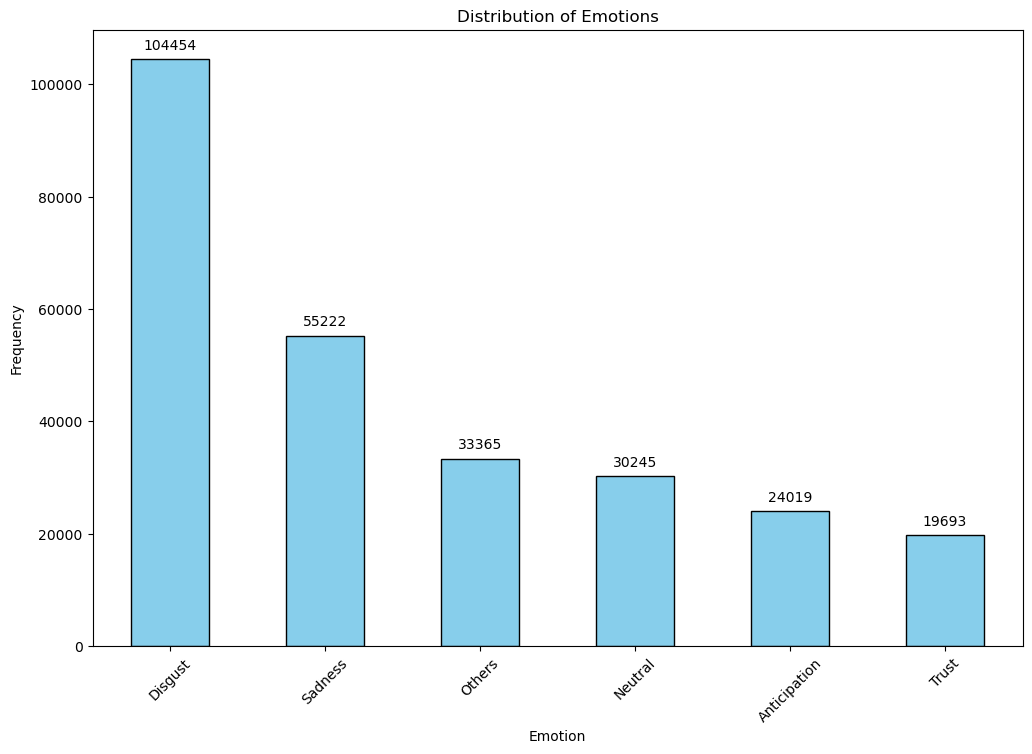

In [95]:
import matplotlib.pyplot as plt

# 假设data已经按照前面的步骤处理过了
plt.figure(figsize=(12, 8))
ax = data['predicted_emotion_english'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)

# 在每个条形上加上具体数据
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()
